In [1]:
import pandas as pd 
import numpy as np 
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import shap
from joblib import dump, load

### Carga de los datos y modelo

In [2]:
# Cargar el modelo
clf_loaded = load(r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\models\clf_final.joblib")

In [3]:
# Cargamos el dataset de test procesado y train
X_train_res = pd.read_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\X_train_res.csv')
X_test_final = pd.read_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\X_test_final.csv')

In [4]:
# Utilizaremos LinearExplainer - RL
explainer = shap.LinearExplainer(clf_loaded, X_train_res, feature_perturbation="interventional")

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [5]:
# Caluclaremos SHAP values en test (positivo -> mayor probabilidad de churn)
shap_values = explainer.shap_values(X_test_final)

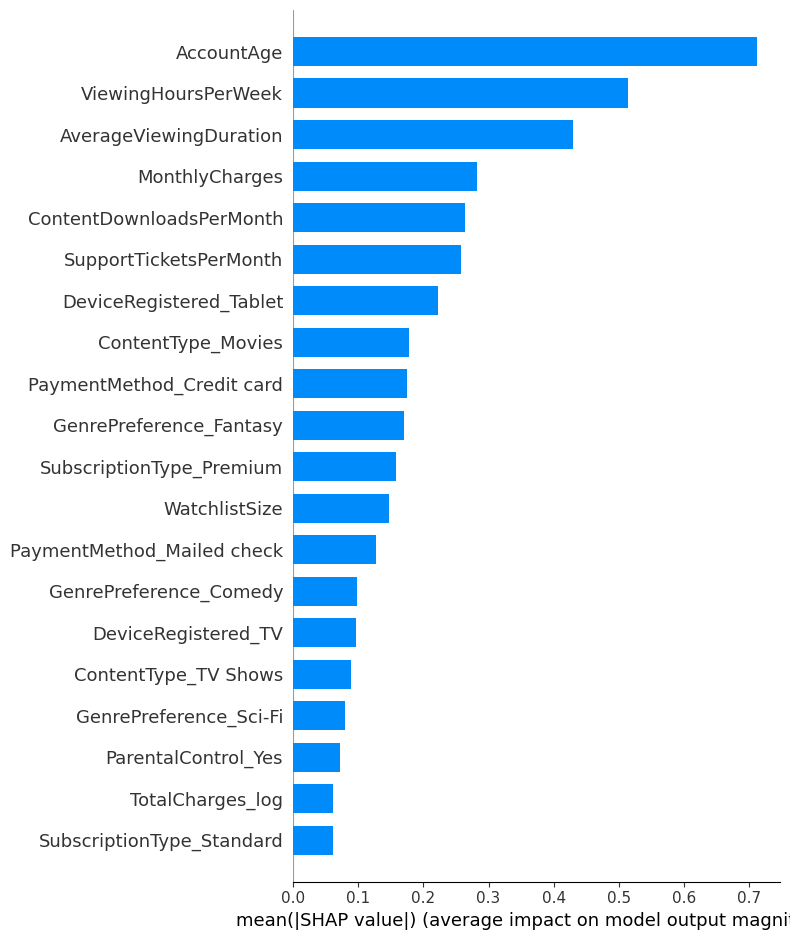

In [6]:
#Resumen de los valores SHAP para cada característica

plt.figure(figsize=(5,4))  
shap.summary_plot(shap_values, X_test_final, plot_type="bar")

In [7]:
plt.savefig(r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\reports\figures\SHAP_features.png", dpi=300)

<Figure size 640x480 with 0 Axes>

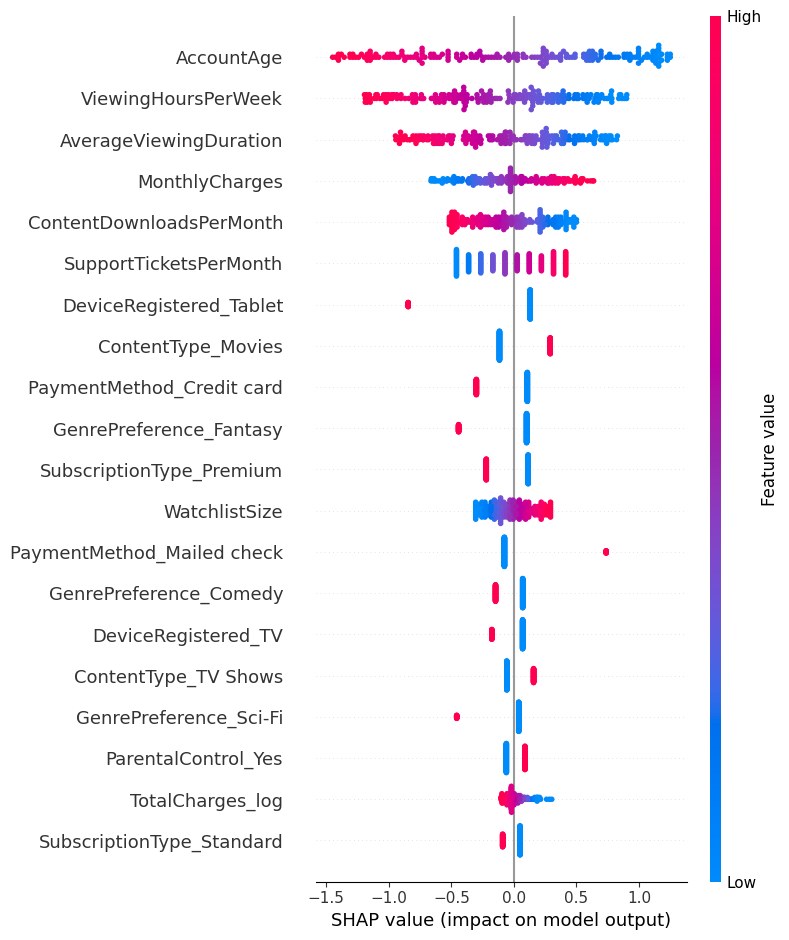

In [8]:
plt.figure(figsize=(5,4))
shap.summary_plot(shap_values, X_test_final)

In [9]:
plt.savefig(r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\reports\figures\SHAP_summary.png", dpi=300)

<Figure size 640x480 with 0 Axes>

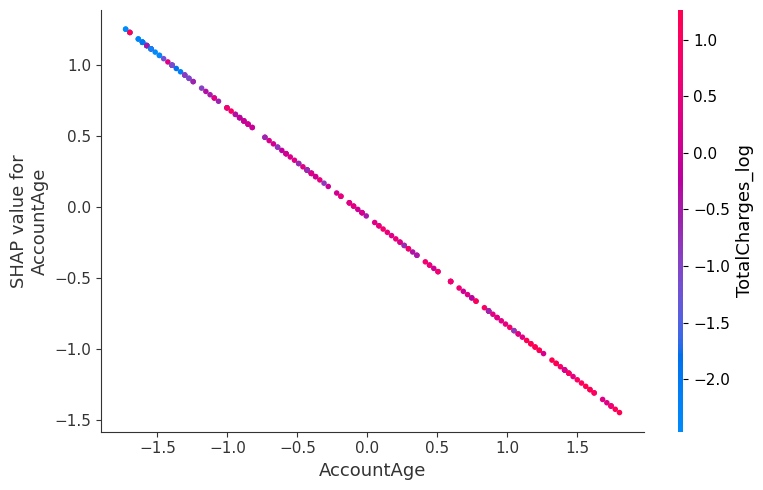

In [12]:
#Plot de dependencia SHAP para AccountAge vs TotalCharges
fig, ax = plt.subplots(figsize=(8,5))

shap.dependence_plot(
    "AccountAge",      
    shap_values,        
    X_test_final,      
    interaction_index="TotalCharges_log",  
    ax=ax,
    show=False
)

plt.tight_layout()
plt.show()

In [13]:
plt.savefig(r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\reports\figures\SHAP_dependence.png", dpi=300)

<Figure size 640x480 with 0 Axes>

### 9. Guardar y exportar para una interfax o visualizador

In [14]:
# Combinar con X_test_final
shap_df = pd.DataFrame(shap_values, columns=X_test_final.columns, index=X_test_final.index)
shap_export = pd.concat([X_test_final, shap_df], axis=1)

# Guardar a CSV
shap_export.to_csv(r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\shap\shap_values_test.csv", index=True)

In [15]:
shap_df.head()

,AccountAge,MonthlyCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,SupportTicketsPerMonth,WatchlistSize,TotalCharges_log,SubscriptionType_Premium,SubscriptionType_Standard,...,MultiDeviceAccess_Yes,DeviceRegistered_Mobile,DeviceRegistered_TV,DeviceRegistered_Tablet,GenrePreference_Comedy,GenrePreference_Drama,GenrePreference_Fantasy,GenrePreference_Sci-Fi,Gender_Male,ParentalControl_Yes
0,0.257945,0.495863,0.837748,0.486162,0.022802,-0.071347,-0.156177,-0.054589,0.113700,0.048757,...,0.042966,-0.019230,-0.176793,0.129849,-0.147046,0.030217,0.101277,0.038522,-0.031680,-0.060525
1,-1.310893,0.271292,0.303191,-0.078365,-0.516524,0.025646,0.043342,-0.069079,0.113700,0.048757,...,-0.048986,0.037319,0.069682,0.129849,-0.147046,0.030217,0.101277,0.038522,-0.031680,0.088170
2,-0.457260,0.110616,0.039559,0.642298,0.230235,-0.071347,-0.255936,-0.051482,0.113700,-0.089943,...,0.042966,0.037319,0.069682,0.129849,0.070091,0.030217,0.101277,0.038522,0.019661,-0.060525
3,-0.780257,-0.415141,0.150457,0.258519,-0.205374,-0.362324,0.043342,-0.019111,-0.221029,0.048757,...,0.042966,0.037319,0.069682,0.129849,0.070091,-0.137337,0.101277,0.038522,0.019661,0.088170
4,0.373301,0.371593,-0.793935,0.157157,0.271722,-0.459317,-0.081357,-0.013801,-0.221029,0.048757,...,0.042966,0.037319,0.069682,0.129849,-0.147046,0.030217,0.101277,0.038522,-0.031680,-0.060525


In [19]:
#Guardado para Power Bi

importance_df = pd.DataFrame({
    'Feature': shap_export.columns,
    'Mean_SHAP': np.abs(shap_export.values).mean(axis=0)
}).sort_values('Mean_SHAP', ascending=False)

importance_df.to_csv(r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\Power_BI\feature_importance_avg.csv", index=False)